In [1]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import shutil
import pandas as pd

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

### **Data Preparation (train)**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Copy the train data to colab storage to read the image faster in next step

import shutil

# Define the source and destination paths
source_folder = '/content/drive/My Drive/DSBA data/DSBA_S3/Deep Learning/kvasir_12k/aug_images/'
destination_folder = '/content/kvasir_image'

# Copy the entire folder,  overwriting the destination if it exists
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

'/content/kvasir_image'

In [4]:
X = np.zeros((12000, 256, 256, 3), dtype=np.uint8)
images_path = '/content/kvasir_image'

for n,img in enumerate(os.listdir(images_path)):
    file_path = os.path.join(images_path, img)
    image = imread(file_path)
    image = resize(image, (256, 256), mode="constant", preserve_range=True)
    X[n] = image

### **Data Preparation (mask)**

In [5]:
# Copy the train data to colab storage to read the image faster in next step

import shutil

# Define the source and destination paths
source_folder = '/content/drive/My Drive/DSBA data/DSBA_S3/Deep Learning/kvasir_12k/aug_masks/'
destination_folder = '/content/kvasir_mask'

# Copy the entire folder,  overwriting the destination if it exists
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

'/content/kvasir_mask'

In [6]:
y = np.zeros((12000, 256, 256, 1), dtype=np.bool_)

mask_path = '/content/kvasir_mask'

for n,mask in enumerate(os.listdir(mask_path)):
    file_path = os.path.join(mask_path, mask)
    mask = imread(file_path)
    mask = rgb2gray(mask)
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask

### **Build The Model**

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"X_train.shape: {X_train.shape}\ny_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}\ny_test.shape: {y_test.shape}")

X_train.shape: (9000, 256, 256, 3)
y_train.shape: (9000, 256, 256, 1)
X_test.shape: (3000, 256, 256, 3)
y_test.shape: (3000, 256, 256, 1)


In [17]:
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(input)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(x)

    return x


#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p


#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    x = tf.keras.layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x


#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 128)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 128)
    s5, p5 = encoder_block(p4, 128)

    b1 = conv_block(p5, 1024) #Bridge

    d1 = decoder_block(b1, s5, 128)
    d2 = decoder_block(d1, s4, 128)
    d3 = decoder_block(d2, s3, 128)
    d4 = decoder_block(d3, s2, 128)
    d5 = decoder_block(d4, s1, 128)

    outputs = Conv2D(n_classes, 1, padding="same", activation='sigmoid')(d5)

    model = Model(inputs, outputs, name="U-Net")
    return model


# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, dtype=tf.float32) # Cast y_true to float32
    y_pred = tf.cast(y_pred, dtype=tf.float32) # Cast y_pred to float32
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [23]:
input_shape = (256, 256, 3)
model_baseline_1 = build_unet(input_shape, n_classes=1)
model_baseline_1.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy', iou_coef])
model_baseline_1.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_138 (Conv2D)       │ (None, 256, 256, 128)  │          3,584 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_139 (Conv2D)       │ (None, 256, 256, 128)  │        147,584 │ conv2d_138[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 128, 128, 128)  │              0 │ conv2d_139[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_140 (Conv2D)       │ (None, 128, 128, 128)  │        147,584 │ max_pooling2d_30[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_141 (Conv2D)       │ (None, 128, 128, 128)  │        147,584 │ conv2d_140[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_31          │ (None, 64, 64, 128)    │              0 │ conv2d_141[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_142 (Conv2D)       │ (None, 64, 64, 128)    │        147,584 │ max_pooling2d_31[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_143 (Conv2D)       │ (None, 64, 64, 128)    │        147,584 │ conv2d_142[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 32, 32, 128)    │              0 │ conv2d_143[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_144 (Conv2D)       │ (None, 32, 32, 128)    │        147,584 │ max_pooling2d_32[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_145 (Conv2D)       │ (None, 32, 32, 128)    │        147,584 │ conv2d_144[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, 16, 16, 128)    │              0 │ conv2d_145[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_146 (Conv2D)       │ (None, 16, 16, 128)    │        147,584 │ max_pooling2d_33[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_147 (Conv2D)       │ (None, 16, 16, 128)    │        147,584 │ conv2d_146[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_34          │ (None, 8, 8, 128)      │              0 │ conv2d_147[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_148 (Conv2D)  

 Total params: 14,951,041 (57.03 MB)

 Trainable params: 14,951,041 (57.03 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history_1 = model_baseline_1.fit(X_train, y_train,
                    batch_size = 32,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 73s 226ms/step - accuracy: 0.7758 - iou_coef: 0.1079 - loss: 14.4433 - val_accuracy: 0.8386 - val_iou_coef: 0.1778 - val_loss: 0.3784
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 58s 207ms/step - accuracy: 0.8354 - iou_coef: 0.1899 - loss: 0.3839 - val_accuracy: 0.8640 - val_iou_coef: 0.2559 - val_loss: 0.3223
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 58s 206ms/step - accuracy: 0.8580 - iou_coef: 0.2533 - loss: 0.3301 - val_accuracy: 0.8902 - val_iou_coef: 0.3617 - val_loss: 0.2693
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 58s 207ms/step - accuracy: 0.8869 - iou_coef: 0.3422 - loss: 0.2772 - val_accuracy: 0.9140 - val_iou_coef: 0.4670 - val_loss: 0.2210
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 58s 207ms/step - accuracy: 0.9129 - iou_coef: 0.4476 - loss: 0.2200 - val_accuracy: 0.9275 - val_iou_coef: 0.5415 - val_loss: 0.1916
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 58s 207ms/step - accuracy: 0.9264 - iou_coef: 0.5141 - loss: 0.1885 - val_accuracy: 0.9331 - v

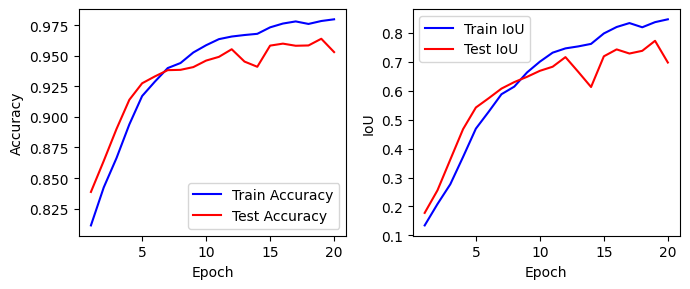

In [25]:
import matplotlib.pyplot as plt

acc2 = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
iou2 = history_1.history['iou_coef']
val_iou = history_1.history['val_iou_coef']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, iou2,'b',label='Train IoU')
axes[1].plot(epochs, val_iou,'r',label='Test IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [27]:
model_baseline_1.save('/content/drive/MyDrive/Colab Notebooks/saved_models/kvasir2_epoch20.hdf5')

### **Hyperparameter Tuning**

In [28]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.5 MB/s eta 0:00:00


In [29]:
# prompt: hyperparameter tuning using kerastuner

import keras_tuner as kt

def build_model(hp):
    input_shape = (256, 256, 3)
    inputs = Input(input_shape)

    # Define hyperparameters for the number of filters in each layer
    filters = hp.Int('filters', min_value=128, max_value=512, step=64)

    # Encoder block
    s1, p1 = encoder_block(inputs, filters)
    s2, p2 = encoder_block(p1, filters)
    s3, p3 = encoder_block(p2, filters)
    s4, p4 = encoder_block(p3, filters)
    s5, p5 = encoder_block(p4, filters)

    # Bridge
    b1 = conv_block(p5, filters * 2)

    # Decoder block
    d1 = decoder_block(b1, s5, filters)
    d2 = decoder_block(d1, s4, filters)
    d3 = decoder_block(d2, s3, filters)
    d4 = decoder_block(d3, s2, filters)
    d5 = decoder_block(d4, s1, filters)

    # Output layer
    outputs = Conv2D(1, 1, padding="same", activation='sigmoid')(d5)

    model = Model(inputs, outputs, name="U-Net")

    # Define hyperparameters for the learning rate and optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3])
    optimizer = hp.Choice('optimizer', values=['adamax', 'rmsprop'])

    if optimizer == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', iou_coef])
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective("val_iou_coef", direction="max"),
    max_trials=5,  # Specify the maximum number of trials
    directory='my_dir',
    project_name='kvasir_tuning',
    overwrite=True
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Trial 5 Complete [00h 09m 49s]
val_iou_coef: 0.09170467406511307

Best val_iou_coef So Far: 0.5845997929573059
Total elapsed time: 00h 50m 56s


In [30]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 72s 223ms/step - accuracy: 0.7337 - iou_coef: 0.0713 - loss: 17522.4570 - val_accuracy: 0.8241 - val_iou_coef: 0.1049 - val_loss: 0.4932
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 58s 204ms/step - accuracy: 0.7873 - iou_coef: 0.1100 - loss: 0.5612 - val_accuracy: 0.8202 - val_iou_coef: 0.1491 - val_loss: 0.4558
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 58s 204ms/step - accuracy: 0.8081 - iou_coef: 0.1212 - loss: 0.4890 - val_accuracy: 0.8112 - val_iou_coef: 0.1743 - val_loss: 0.4558
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 58s 204ms/step - accuracy: 0.8233 - iou_coef: 0.1385 - loss: 0.4363 - val_accuracy: 0.8206 - val_iou_coef: 0.1764 - val_loss: 0.4227
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 58s 205ms/step - accuracy: 0.8325 - iou_coef: 0.1676 - loss: 0.3988 - val_accuracy: 0.8391 - val_iou_coef: 0.2167 - val_loss: 0.3830
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 58s 205ms/step - accuracy: 0.8360 - iou_coef: 0.1869 - loss: 0.3835 - val_accuracy: 0.8535 

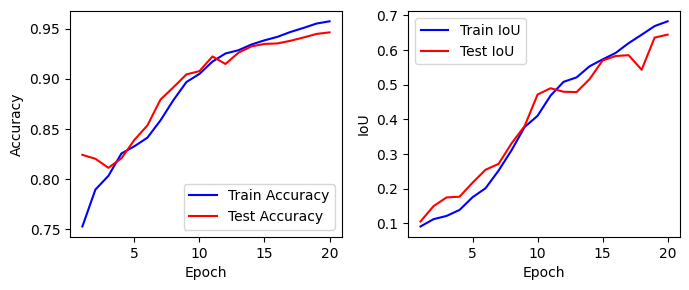

In [31]:
import matplotlib.pyplot as plt

acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
iou2 = history.history['iou_coef']
val_iou = history.history['val_iou_coef']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, iou2,'b',label='Train IoU')
axes[1].plot(epochs, val_iou,'r',label='Test IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [32]:
best_model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/kvasir2_epoch20_tuned.hdf5')